IMPORT THE LIBRARIES

In [205]:
#import the relevant modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pytz
import datetime
import plotly.express as px
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression


DATA CLEANING FUNCTION


In [161]:
#create data cleaning function
def data_cleaning(filepath):
    #import the file path
    df = pd.read_csv(filepath)
    
    #remove the first row
    df.drop(index=df.index[0],axis=0,inplace=True)
    # delete leaky features
    df.drop(columns=["Unnamed: 1","Unnamed: 2","Unnamed: 3",
                "Unnamed: 5","Unnamed: 6"],inplace=True)
    
    #rename the column with the closing price
    df["Closing Price"] = df["Unnamed: 4"]
    
    #rename date column
    df["Date"] = df["GBPUSD Historical Data"]
    #delete the new added columnn
    df.drop(columns=["GBPUSD Historical Data","Unnamed: 4"],inplace=True)
    
    #format time
    df["Date"]=df["Date"].str.replace("/","-")
    df["Date"]= pd.to_datetime(df["Date"])
    #convert closing prices to float
    df["Closing Price"]=df["Closing Price"].astype(float).sort_values()
    
    #sort the time from past to present
    df = df.sort_values(["Date","Closing Price"],ascending=(True,True))
    #set index, convert from UTC to local time
    df= df.set_index("Date").tz_localize("UTC").tz_convert("Africa/Johannesburg")
    
    #create a shift column based on closing prices
    df["Shift Price"]=df["Closing Price"].shift(1)
    df.dropna(inplace=True)
    #return the dataframe
    return df

In [162]:
#call our function
df = data_cleaning(r"C:\Users\IFB19-039\Desktop\machine learning\GBPUSD_historical_data.csv")
df.head()

,Closing Price,Shift Price
Date,,
2021-11-01 16:00:00+02:00,1.36601,1.36857
2021-11-01 20:00:00+02:00,1.36633,1.36601
2021-11-02 00:00:00+02:00,1.36503,1.36633
2021-11-02 04:00:00+02:00,1.36595,1.36503
2021-11-02 08:00:00+02:00,1.36328,1.36595


EDA

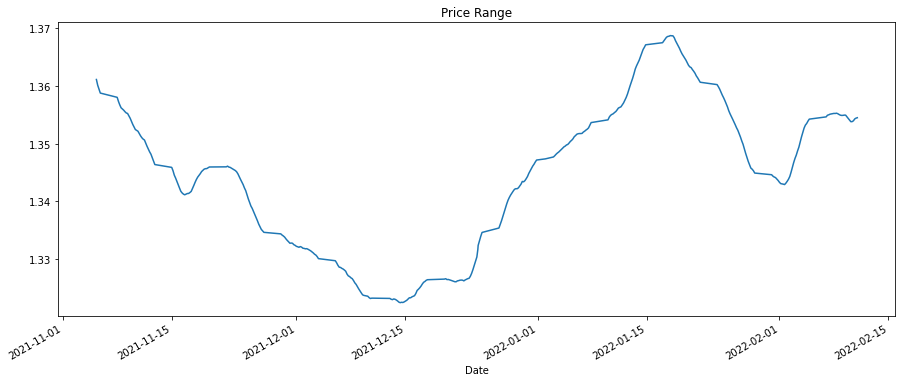

In [158]:
fig, ax = plt.subplots(figsize=(15, 6))
df["Closing Price"].rolling(24).mean().plot(ax=ax,title="Price Range");

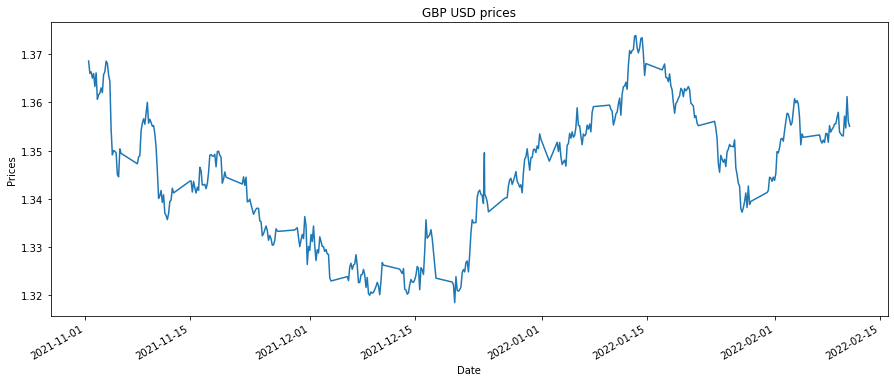

In [159]:
#line plot using pandas
fig, ax = plt.subplots(figsize=(15, 6))
df["Closing Price"].plot(title="GBP USD prices",ax=ax)
plt.xlabel("Date")
plt.ylabel("Prices");

In [166]:
correlation = df.select_dtypes("number").corr()
correlation

,Closing Price,Shift Price
Closing Price,1.000000,0.985873
Shift Price,0.985873,1.000000


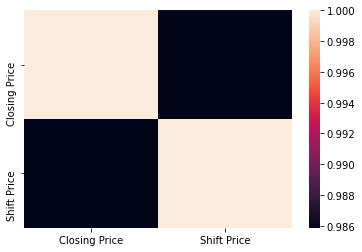

In [168]:
sns.heatmap(correlation);


Text(0.5, 1.0, 'Closing Prices Autocorrelation')

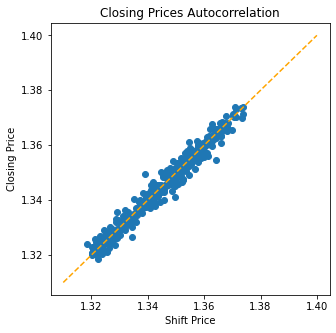

In [182]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(x=df["Shift Price"],y=df["Closing Price"])
ax.plot([1.31,1.40],[1.31,1.40],linestyle="--",color="orange")
plt.xlabel("Shift Price")
plt.ylabel("Closing Price")
plt.title("Closing Prices Autocorrelation")

MODEL BUILDING

In [184]:
#split the dataset
target = "Closing Price"
y=df[target]
X=df.drop(columns=target)

In [188]:
#cuoff by the first 80% of the data
cutoff = int(len(X)*0.8)

X_train, y_train = X.iloc[:cutoff],y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:],y.iloc[cutoff:]

In [189]:
#check if you are correct
len(X_train)+ len(X_test) == len(y_train) + len(y_test)

True

BUILD THE BASELINE

In [192]:
#build a baseline for the model
y_mean = y_train.mean()
round(y_mean,5)

1.34347

In [194]:
y_pred_baseline = [y_mean]*len(y_train)
mae_baseline = mean_absolute_error(y_train,y_pred_baseline)

print("Mean P2 Reading:", round(y_train.mean(), 5))
print("Baseline MAE:", round(mae_baseline, 5))

Mean P2 Reading: 1.34347
Baseline MAE: 0.01237


BUILD AND FIT THE MODEL

In [208]:
#build and fit the model
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

METRICS (MAE)

In [196]:
#Calculate the training and test mean absolute error for your model.
training_mae = mean_absolute_error(y_train,model.predict(X_train))
test_mae = mean_absolute_error(y_test,model.predict(X_test))
print("Training MAE:", round(training_mae, 5))
print("Test MAE:", round(test_mae, 5))

Training MAE: 0.00168
Test MAE: 0.00162


COMMUNICATION

In [198]:
#communicate the results
#extract intercept and coefficients of the model
model.intercept_

0.020217396651506014

In [200]:
intercept = round(model.intercept_,5)
coefficient = round(model.coef_[0],5)

print(f"Closing Price = {intercept} + ({coefficient} * Shift Price)")

Closing Price = 0.02022 + (0.98493 * Shift Price)


In [201]:
#data frame for true predictions and the actual values
df_pred_test = pd.DataFrame(
    {
        "y_test":y_test,
        "y_pred":model.predict(X_test)
        
    }
    )
df_pred_test.head()

,y_test,y_pred
Date,,
2022-01-21 08:00:00+02:00,1.35685,1.358976
2022-01-21 12:00:00+02:00,1.35725,1.356623
2022-01-21 16:00:00+02:00,1.35568,1.357016
2022-01-21 20:00:00+02:00,1.35516,1.355470
2022-01-24 00:00:00+02:00,1.35607,1.354958


In [204]:
fig = px.line(df_pred_test,labels={"value":"Closing Prices"})
fig.show()
